# **Assignment 4 - Variational Autoencoders**

In this assignment, we will train a model to produce new human faces with variational autoencoders (VAEs). 
Variational autoencoders let us design complex generative models of data, and fit them to large datasets. They can generate images of fictional celebrity faces (as we'll do in this assignment), high-resolution digital artwork and many more tasks. These models also yield state-of-the-art machine learning results in image generation and reinforcement learning. Variational autoencoders (VAEs) were defined in 2013 by Kingma and Wellings [1].

In this assignment, you will build, train and analyze a VAE with the CelebA dataset. You will analyze how well images can be reconstructed from the lower dimensional representations and try to generate images that look similar to the images in the CelebA dataset.

[1] Kingma, Diederik P., and Max Welling. "Auto-encoding variational bayes." arXiv preprint arXiv:1312.6114 (2013). 


# **Section 1: Variational Autoencoders**


Let us recall the structure of the variational autoencoder:

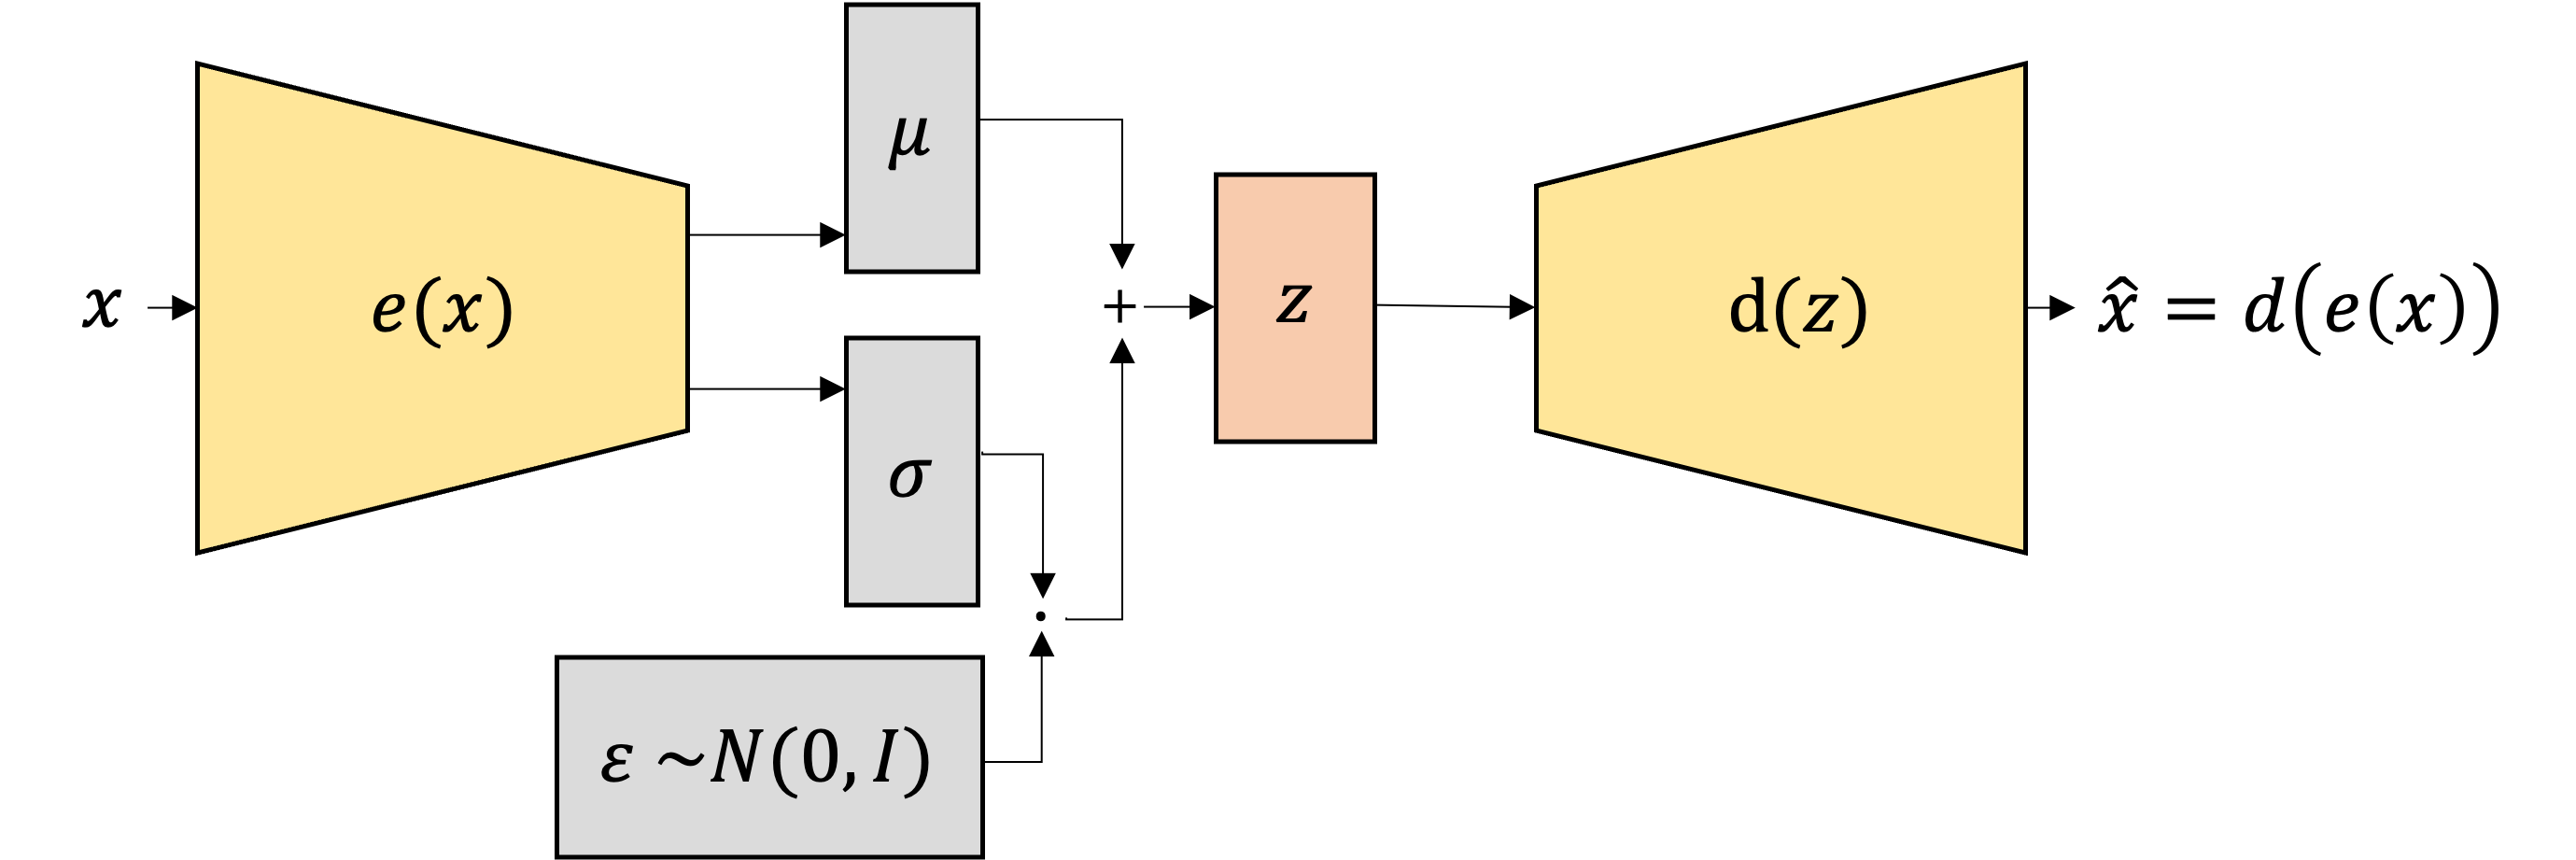

**Imports**

Before we begin, we import the needed libraries. 


You may modify the starter code as you see fit, including changing the signatures of
functions and adding/removing helper functions. However, please make sure that we can understand what you are doing and why.

In [1]:
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as nnF
from torchvision.utils import make_grid
import torch.utils.data as data_utils
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision.transforms.functional as F
from torchvision.utils import make_grid
import os
import zipfile
from torch.nn.modules import KLDivLoss

%pip install wget   
import wget

# use GPU for computation if possible: Go to RUNTIME -> CHANGE RUNTIME TYPE -> GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=b07744279a77bf29850d8fc67e6959830f04318a4b0d84237ecd51a53122caf4
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget


Connect to your Google Drive, select the path in your drive for saving the checkpoints of your model, which we will train later.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

# Path to save the dataset.
PATH_TO_SAVE_MODEL = '/content/gdrive/MyDrive/Colab Notebooks/assignment4/' # TODO - UPDATE ME!

Mounted at /content/gdrive


Define random seeds in order to reproduce your results.

In [3]:
# TO DO: Set random seeds - to your choice
# to make r.v. determinstic
torch.manual_seed(100)         # Insert any integer
torch.cuda.manual_seed(100)    # Insert any integer

## Question 1. Basic Principles (10 %)




### Part (a) -- 3%

What is the difference between deterministic autoencoder we saw in class and the variational autoencoder? 

#### Our Answer

*Deterministic* autoencoders, as we saw in class, fix the latent vector $z$ to a deterministic mapping of the input y. This way, our network has to learn a relatively large vector.


*Variational* autoencoders aim to reduce the dimentionality of the latent the network needs to learn. It does that by allowing stochastic mapping, meaning a gaussian noise is added to the input. We than force the output distribution that the network is learning to be as close as possible to the Standard Normal Diviation $N(0,1)$. 


### Part (b) -- 3%
In which manner Variational Autoencoder is trained? Explain.


#### Our Answer

To get the loss function, due to the approximation to the standard normal diviation our latent is simply $z=μ+σ⊙ϵ$, where $ϵ∼N(0,1)$. This way we only need to train $μ$ and $σ$ and don't use regular backpropagation.

It is possible to get better results if we balance the ELBO. We manage that by adding a hyperparemeter $β$ such that:
$L(ϕ, θ) = β · D_{KL}(q_θ(z|y)||p_ϕ(z)) − E_{z∼qθ(z|y)}[log p_ϕ(y|z)]$ 


### Part (c) -- 4%

In class we saw another generative model, known as generative adversarial network (GAN). What are the differences in terms of task objective between GANs and VAEs? Give an example for a task which a VAE is more suitable than GAN, and vice versa.

#### Our Answer

VAEs and GANs differ in how they are trained. VAEs use an unsupervised approach with a stochastic latent vector, while GANs use a supervised technique with an adversary neural network.

Because they learn from existing data, and especially when adding the hyperparemeter $β$ as noted above, VAEs are better at generating new information such as people's faces. It learns the features of the image (such as "nose", "eyes" and "skin color"), and is able to create new ones that are combinations of data learned from several inputs (the new nose is now 10% this and 90% that, with this skin tone). 

Because they need to "cheat" the adversary, GANs are very good at creating specifically what the user asked for. This is why they can be used for, for example, text-to-image generators.

In reality, VAEs and GANs will pften be used togather, for example this way
we can generate new images and make the resolution much higher.


## Question 2. Data (15 %)

In this assignement we are using the CelebFaces Attributes Dataset (CelebA).

The CelebA dataset, as its name suggests, is comprised of celebrity faces. The images cover large pose variations, background clutter, diverse people, supported by a large quantity of images and rich annotations. This data was originally collected by researchers at MMLAB, The Chinese University of Hong Kong.

**Overall**

- 202,599 number of face images of various celebrities
- 10,177 unique identities, but names of identities are not given
- 40 binary attribute annotations per image
- 5 landmark locations

In this torchvision version of the dataset, each image is in the shape of
$[218,178,3]$ and the values are in $[0,1]$.

Here, you will download the dataset to the Google Colab disk. It is highly recommended not to download the dataset to your own Google Drive account since it is time consuming.

In [4]:
data_path = "data" ## TO DO -- UPDATE ME!
# Path to folder with the dataset
dataset_folder = f"{data_path}/celeba"
os.makedirs(dataset_folder, exist_ok=True)


In [5]:
base_url = "https://graal.ift.ulaval.ca/public/celeba/"

file_list = [
    "img_align_celeba.zip",
    "list_attr_celeba.txt",
    "identity_CelebA.txt",
    "list_bbox_celeba.txt",
    "list_landmarks_align_celeba.txt",
    "list_eval_partition.txt",
]

for file in file_list:
    url = f"{base_url}/{file}"
    if not os.path.exists(f"{dataset_folder}/{file}"):
        wget.download(url, f"{dataset_folder}/{file}")

with zipfile.ZipFile(f"{dataset_folder}/img_align_celeba.zip", "r") as ziphandler:
    ziphandler.extractall(dataset_folder)

### Part (a) -- 5%

Apply transformations:

The data is given as PIL (Python Imageing Library) images. Since we are working with PyTorch, we wish to apply transformations to the data in order to process it properly.

Here you should apply transformations to the data. There are many kinds of transformations which can be found here: https://pytorch.org/vision/stable/transforms.html. Note that transformations can be chained together using Compose method.

Think which transformations can be suitable for this task and apply it in the form of: 

trfm = transforms.Compose([transforms.transform1(),transforms.transform2(),...])

We recommend to consider:
- transforms.ToTensor()
- transforms.Resize()

In [22]:
width = 178
height = 218
trfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=(height,width))
])

training_data = datasets.CelebA(root=data_path, split='train', download=False, transform=trfm) #load the dataset (without download it directly) from our root directory on google drive disk. 
test_data = datasets.CelebA(root=data_path, split='test', download=False, transform=trfm)

### Part (b) -- 5%

In order to get in touch with the dataset, and to see what we are dealing with (which is always recommended), we wish to visualize some data samples from the CelebA dataset.

Write a function: show():

INPUT: Python list of length 32 where each element is an image, randomly selected from the training data.

OUTOUT: Showing a 8X4 grid of images.

In [7]:
def show(imgs):
    fig, axs = plt.subplots(8, 4, figsize=(16, 20))
    for i in range(8):
      for j in range(4):
        axs[i, j].imshow(imgs[4*i + j])
        axs[i, j].axis('off')
    plt.show()
    return None

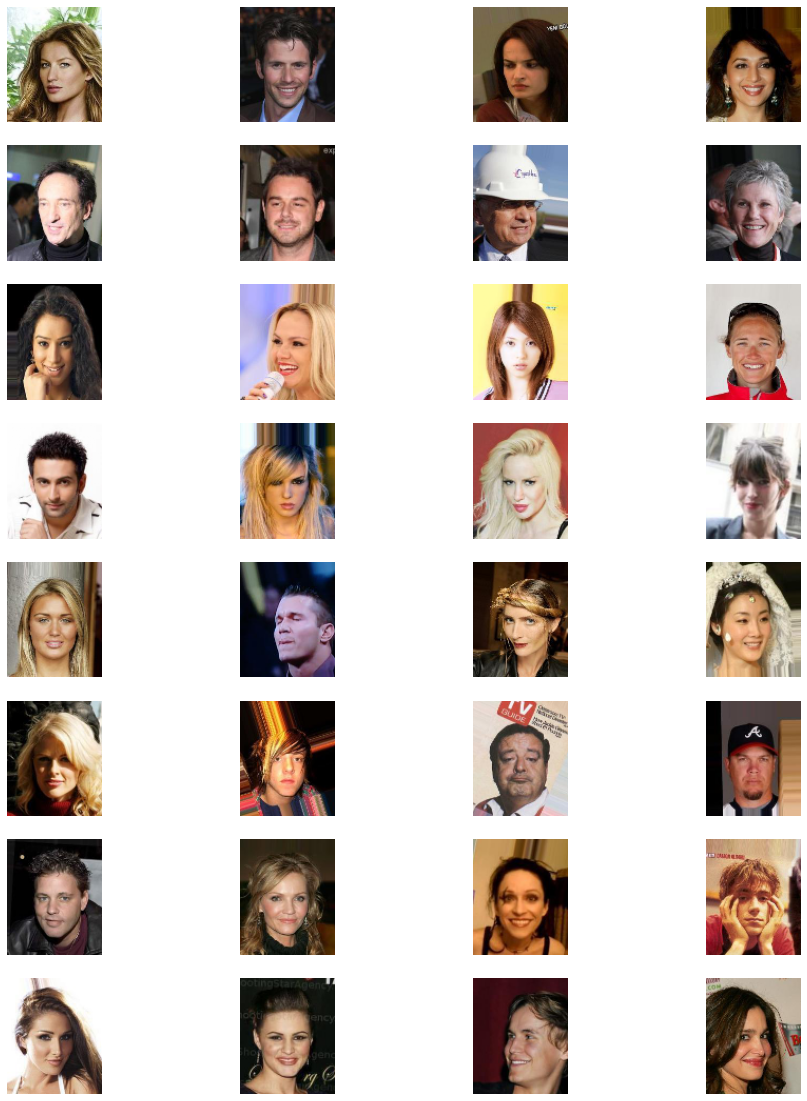

In [8]:
num_images = len(training_data)
indices = random.sample(range(num_images), 32)
imgs = [training_data[i][0].permute(1,2,0) for i in indices]
show(imgs)

### Part (c) -- 5%

Extrapolate in the image domain:

Here, randomly take 2 images from the training dataset, combine them together and plot the result. For example, consider $X_1$ and $X_2$ to be 2 images randomly taken from the training data. Plot $\alpha\cdot X_1 + (1-\alpha)\cdot X_2$. 

Explain the results, is extrapolation in the image domain reasonable?

Note: Recall that the images should be in the $[0,1]$ interval.

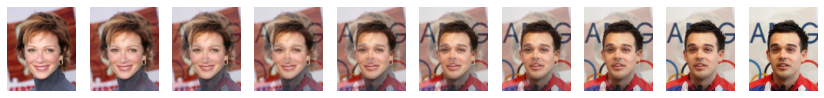

In [9]:
indices = random.sample(range(len(training_data)), 2)
img1, img2 = [training_data[i][0].permute(1,2,0) for i in indices]
fig = plt.figure(figsize=(16, 20))
for i in range(10):
  alpha = i / 10
  fig.add_subplot(1, 11, i+1)
  img = alpha*img1 + (1-alpha)*img2
  plt.imshow(img)
  plt.axis('off')



#### Our Answer

Extrapulating in this manner in the image domain makes ammusing results, but not very useful ones. Since not all images were taken in exactly the same way, and not all human's faces are shaped exactly the same way, we will inevitably get results like this one:
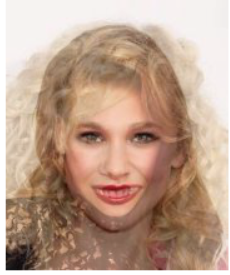


We can see both faces in this mushed-togather image. While in this case the facial features almost align, we still clearly see, for example, two mouths stacked one on top of the other. This is not the desired result when we try to emulate new human faces.

## Question 3. VAE Foundations (15 %)


Let us start by recalling the analytical derivation of the VAE.


The simplest version of VAE is comprised of an encoder-decoder architecture.
The *encoder* is a neural network which its input is a datapoint $x$, its output is a hidden representation $z$, and it has weights and biases $\theta$. We denote the encoder's mapping by $P_{\theta}(z|x)$. The *decoder* is another neural network which its input is the data sample $z$, its output is the reconstructed input $x$, and its parameters $\phi$. Hence, we denote the decoder's mapping by $P_{\phi}(x|z)$.

The goal is to determine a posterior distribution $P_{\theta}(z|x)$ of a latent variable $z$ given some data evidence $x$. However, determining this posterior distribution is typically computationally intractable, because according to Bayes:

$(1)$ $P(z|x) = \frac{P(x|z)P(z)}{P(x)}$

The term $P(x)$ is called the evidence, and we can calculate it by marginalization on the latent variable:

$P(x) = \int_{z}P(x|z)P(z)dz$

Unfortunately, this term is intractable because it requires computation of the integral over the entire latent space $z$. To bypass this intractability problem we approximate the posterior distribution with some other distribution $q(z|x_i)$. This approximation is made by the KL-divergence:

$(2)$ $D_{KL}\big(q(z|x_i)||P(z|x_i)\big) = \int_{z}q(z|x_i)\cdot\log\big(\frac{q(z|x_i)}{P(z|x_i)}\big)dz = -\int_{z}q(z|x_i)\cdot\log\big(\frac{P(z|x_i)}{q(z|x_i)}\big)dz \geq 0$

Applying Bayes’ theorem to the above equation yields,

$(3)$ $D_{KL}\big(q(z|x_i)||P(z|x_i)\big) = -\int_{z}q(z|x_i)\cdot\log\big(\frac{P(x_i|z)P(z)}{q(z|x_i)P(x_i)}\big)dz \geq 0$

This can be broken down using laws of logarithms, yielding,

$(4)$ $-\int_{z}q(z|x_i)\cdot\big[\log\big(\frac{P(x_i|z)P(z)}{q(z|x_i)}\big)-\log(P(x_i))\big]dz \geq 0$

Distributing the integrand then yields,

$(5)$ $-\int_{z}q(z|x_i)\cdot\log\big(\frac{P(x_i|z)P(z)}{q(z|x_i)}\big)dz+\int_{z}q(z|x_i)\log(P(x_i))dz \geq 0$

In the above, we note that $log(P(x))$ is a constant and can therefore be pulled out of the second integral above, yielding,

$(6)$ $-\int_{z}q(z|x_i)\cdot\log\big(\frac{P(x_i|z)P(z)}{q(z|x_i)}\big)dz+\log(P(x_i))\int_{z}q(z|x_i)dz \geq 0$

And since $q(z|x_i)$ is a probability distribution it integrates to 1 in the above equation, yielding,

$(7)$ $-\int_{z}q(z|x_i)\cdot\log\big(\frac{P(x_i|z)P(z)}{q(z|x_i)}\big)dz+\log(P(x_i)) \geq 0$

Then carrying the integral over to the other side of the inequality, we get,

$(8)$ $\log(P(x_i)) \geq \int_{z}q(z|x_i)\cdot\log\big(\frac{P(x_i|z)P(z)}{q(z|x_i)}\big)dz$

<!-- Applying rules of logarithms, we get,

$(9)$ $\log(P(x)) \geq \int_{z}q(z|x)\cdot\big[\log\big(P(x|z)\big)+\log\big(P(z)\big)-\log\big(q(z|x)\big)\big]dz$

Recognizing the right hand side of the above inequality as Expectation, we write,

$(10)$ $\log(P(x)) \geq E_{~q(z|x)}\big[\log\big(P(x,z)\big)-\log\big(q(z|x)\big)\big]dz$ -->

From Equation $(8)$ it follows that:

$(9)$ $\log(P(x_i)) \geq \int_{z}q(z|x_i)\cdot\log\big(\frac{P(z)}{q(z|x_i)}\big)dz + \int_{z}q(z|x_i)\cdot\log\big(P(x_i|z)\big)dz$

Which is equivalent to:

$(10)$ $\log(P(x_i)) \geq -D_{KL}\big(q(z|x_i)||P(z)\big) + E_{~q(z|x_i)}\big[\log\big(P(x_i|z)\big)\big]$



The right hand side of the above equation is the Evidence Lower BOund (ELBO). Its bounds $\log(P(x))$ which is the term we seek to maximize. Therefore, maximizing the ELBO maximizes the log probability of our data. 


### Part (a) -- 5%
 A we see above, the $ELBO = -D_{KL}\big(q(z|x_i)||P(z)\big) + E_{~q(z|x_i)}\big[\log\big(P(x_i|z)\big)\big]$ is comprised of 2 terms. Explain the meaning of each one of them in terms of a loss function.



#### Our Answer

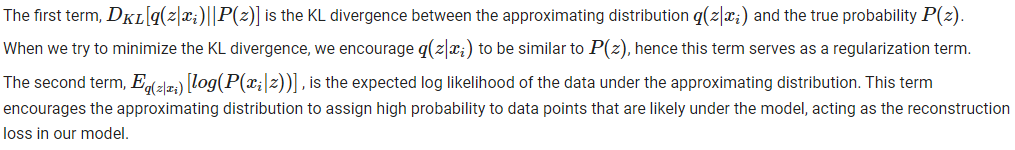

### Part (b) -- 10%

 As we saw in class, in traditional variational autoencoder we assume:

$P(z)$ ~ $N(\mu_p,\sigma_{p}^2) = \frac{1}{\sqrt{2\pi\sigma_{p}^2}}\exp\big(-\frac{(z-\mu_p)^2}{2\sigma_{p}^2}\big)$

and

$q(z|x)$ ~ $N(\mu_q,\sigma_{q}^2) = \frac{1}{\sqrt{2\pi\sigma_{q}^2}}\exp\big(-\frac{(z-\mu_q)^2}{2\sigma_{q}^2}\big)$

Assume $\mu_p = 0$ and $\sigma_{p}^2 = 1$. Show that:

$ -D_{KL}\big(q(z|x_i)||P(z)\big) = \frac{1}{2}\big[1+\log(\sigma_{q}^2)-\sigma_{q}^2-\mu_q^2\big]$ 

 

#### Our Answer

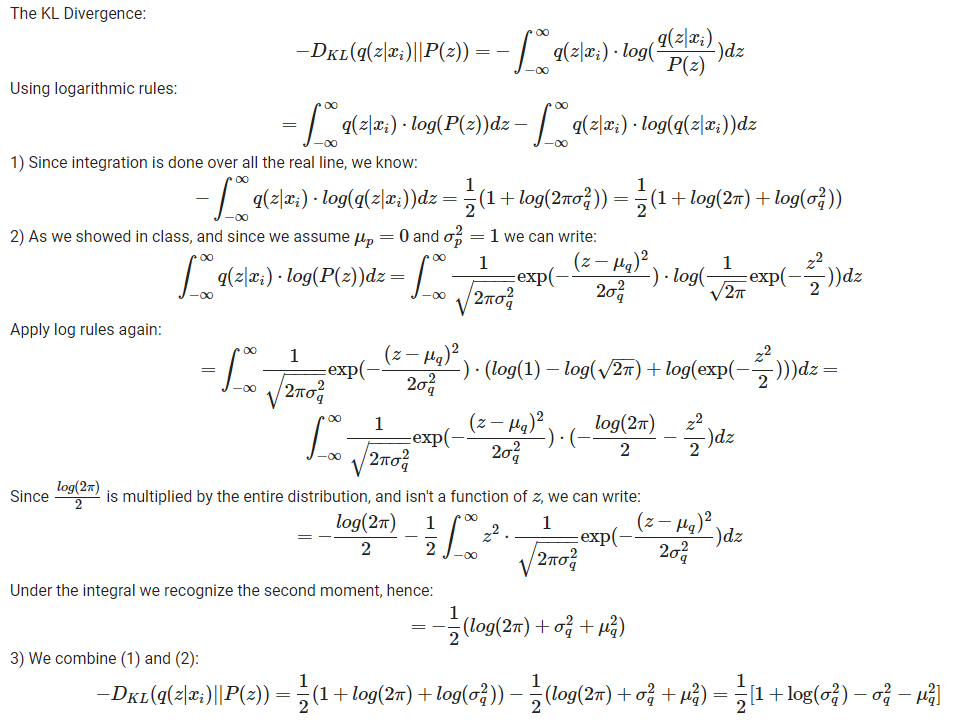


**Minimizing** the loss function, over a batch in the dataset now can be written as:

$\mathcal{L(\theta,\phi)} = -\sum_j^J\bigg(\frac{1}{2}\big[1+\log(\sigma_{q_j}^2)-\sigma_{q_j}^2-\mu_{q_j}^2\big]\bigg) - \frac{1}{M}\sum_i^M\bigg(E_{~q_{\theta}(z|x_i)}\big[\log\big(P_{\phi}(x_i|z)\big)\big]\bigg)$

where $J$ is the dimension of the latent vector $z$ and $M$ is the number of samples stochastically drawn from the dataset.

## Question 4. VAE Implementation (25 %)

As seen in class, a suitable way to extract features from dataset of images is by convolutional neural network (CNN). Hence, here you will build a convolutional VAE.
\
The basic idea is to start from full resolution images, and by convolutional kernels extract the important features of the dataset. Remember that the output of the VAE should be in the same dimensions $(H_1,W_1,C_1)$ as the input images. 

**The encoder** should be comprised of convolutional layers (nn.Conv2d). Recall that the dimension of the input images is changing according to:

$Z = \bigg(H_2(=\frac{H_1-F+2P}{S}+1),W_2(=\frac{W_1-F+2P}{S}+1),C_2\bigg)$

where $S$ is the stride, $F$ is the kernel size, $P$ is the zero padding and $C_2$ is the selected output channels. $Z$ is the output image.

**The decoder** should reconstruct the images from the latent space. In order to enlarge dimensions of images, your network should be comprised of transposed convolutional layers (nn.ConvTranspose2d). See the following images of the operation of transpose convolution to better understand the way it works.




***Transposed Convolution with Stride = 1***

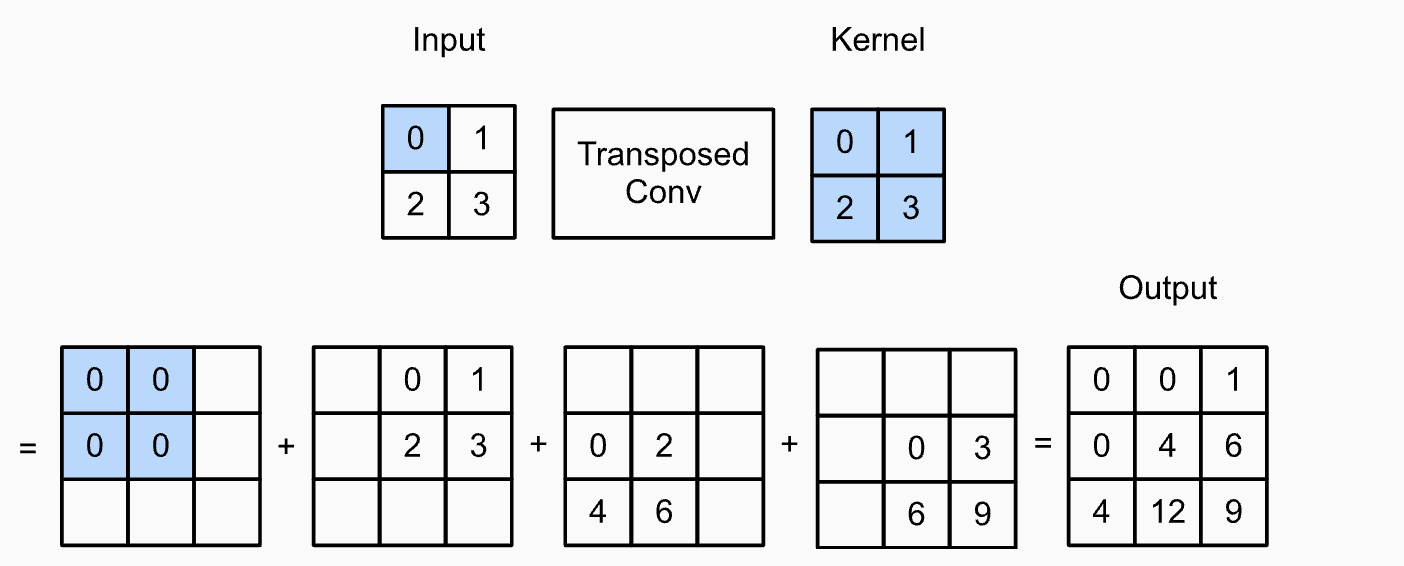

***Transposed Convolution with Stride = 2***
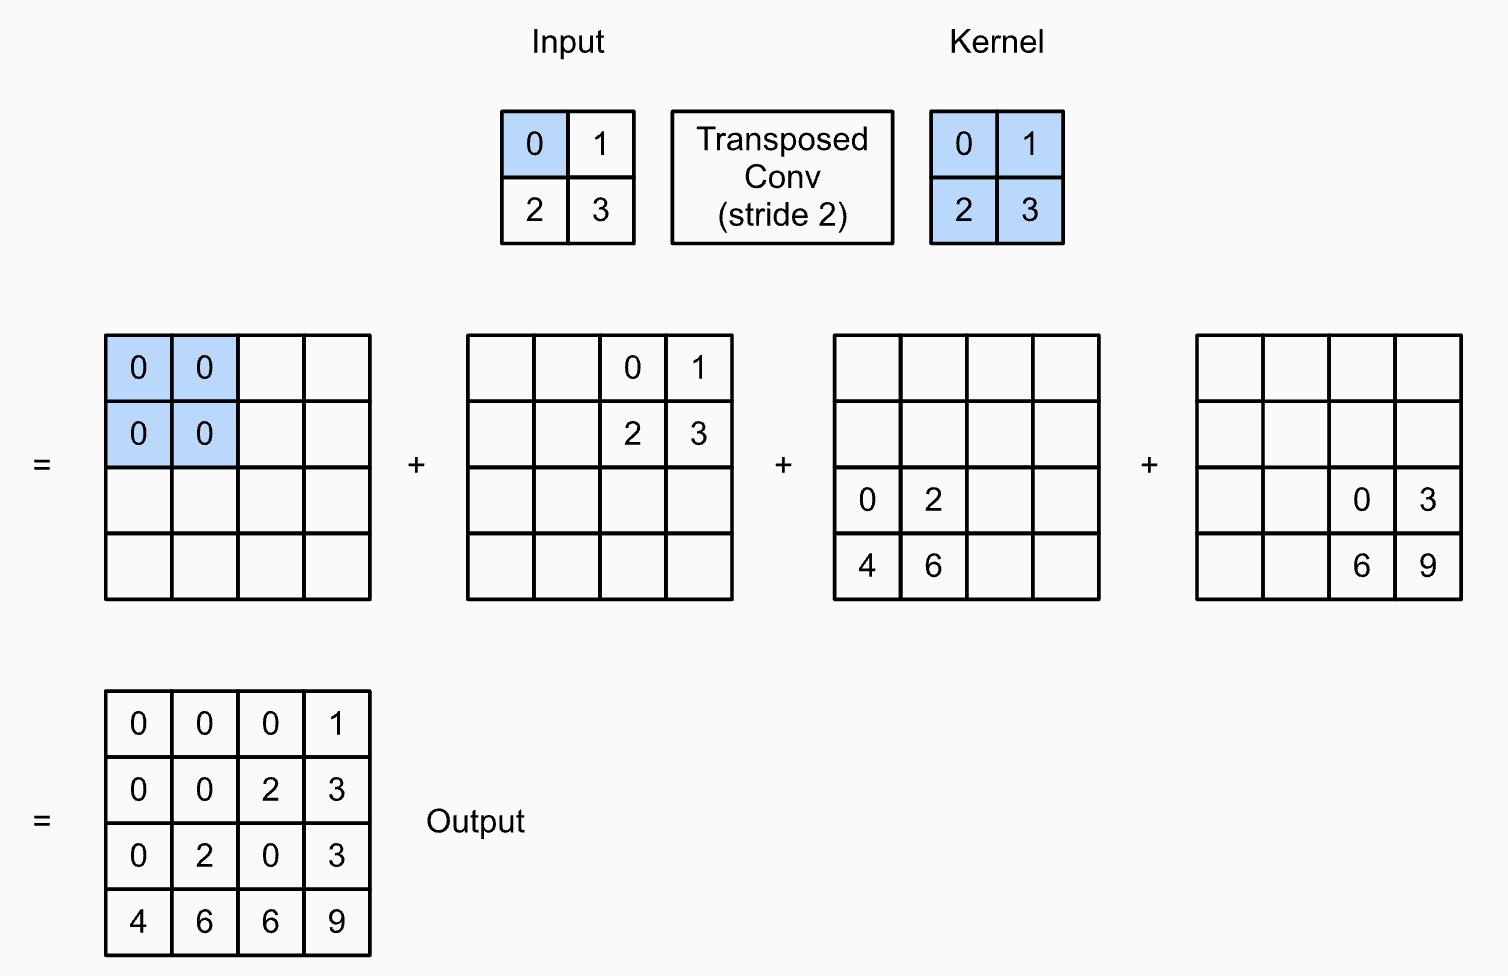

The architecture of your VAE network should be in the following form:


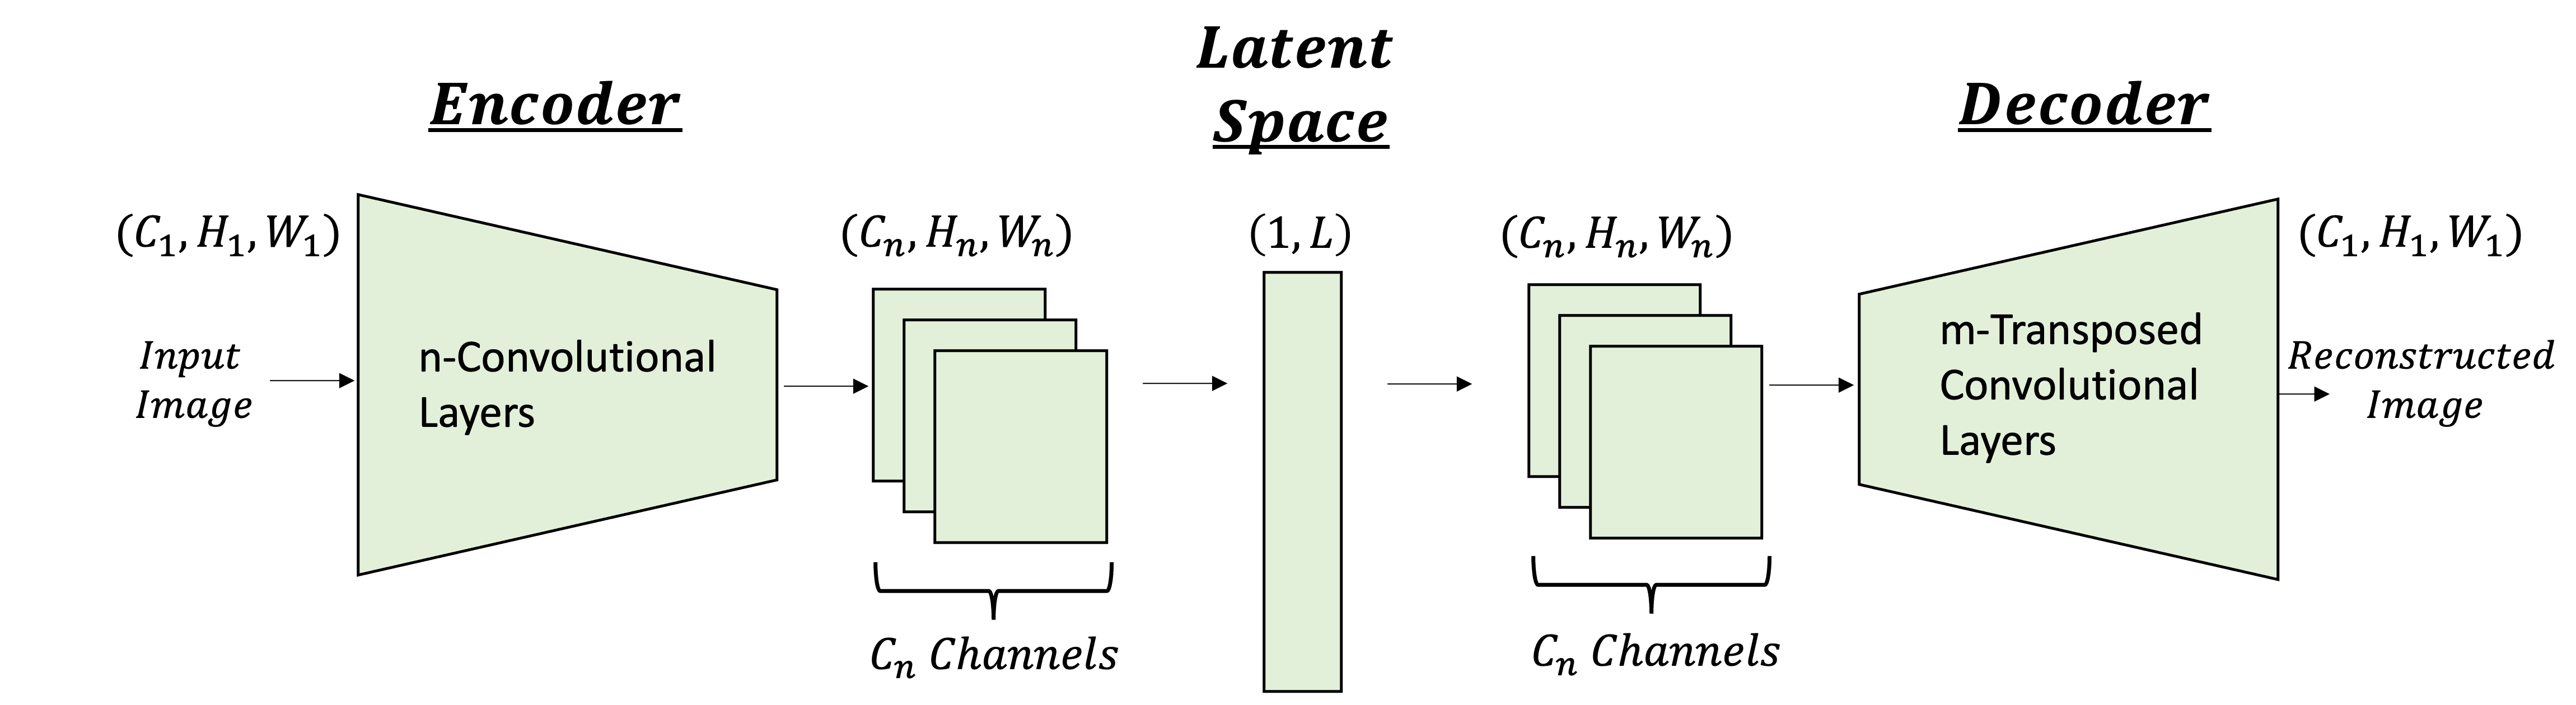

### Part (a) -- 7%

 **Encoder**

Here, you will implement the architecture of the encoder. 

The encoder should consist of 4 Blocks as follows:

BLOCK 1: 
- Convolutional layer (nn.Conv2D(in_channels, num_hidden, kernel_size=(3,3), stride=(2,2)))
- Batch Normalization(num_hidden)
- Activation Function: nn.ReLU()

BLOCK 2: 
- Convolutional layer (nn.Conv2D(num_hidden, num_hidden * 2, kernel_size=(3,3), stride=(2,2))
- Batch Normalization(num_hidden * 2)
- Activation Function: nn.ReLU()

BLOCK 3: 
- Convolutional layer (nn.Conv2D(num_hidden * 2, num_hidden * 4, kernel_size=(3,3), stride=(2,2))
- Batch Normalization(num_hidden * 4)
- Activation Function: nn.ReLU()

BLOCK 4: 
- Convolutional layer (nn.Conv2D(num_hidden * 4, num_hidden * 8, kernel_size=(3,3), stride=(2,2))
- Batch Normalization(num_hidden * 8)
- Activation Function: nn.ReLU()

In addidion to the 4 Blocks, you should add the following linear layers:

Linear $\mu$: 
- nn.Linear( ___ ,latent). 

Linear $\log(\sigma)$: 
- nn.Linear( ___ ,latent).

**NOTES:** 

- The input of the linear layer should be according to the size of the images you picked in the transformation part. (If you did resize the images)

- Consider using Padding in the convolutional layers to correct mismatches in sizes.

- In the forward function, you will have to reshape the output from the 4'th block to $(H_4\cdot W_4\cdot C_4 , latent)$, where $H_4$ is the height of the output image from the 4'th block, $W_4$ is the width of the output image from the 4'th block and $C_4$ is num_hidden*8 (number of channels of the output image from the 4'th block).

**You can change any parameter of the network to suit your code - this is only a recommendation.**

In [23]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, latent, width, height):
        super(Encoder, self).__init__()
        # YOUR CODE GOES HERE:
        reduce_W = (1+(1+(1+(1+width)//2)//2)//2)//2
        reduce_H = (1+(1+(1+(1+height)//2)//2)//2)//2
        self.reduce_size = 8*num_hiddens*reduce_W*reduce_H
        self.num_hiddens = num_hiddens
        self.latent = latent
        self.block1 = nn.Sequential(nn.Conv2d(in_channels, num_hiddens, kernel_size=(3,3), stride=(2,2),padding=(1,1)),
                                    nn.BatchNorm2d(num_hiddens),
                                    nn.ReLU())
        
        self.block2 = nn.Sequential(nn.Conv2d(num_hiddens, num_hiddens*2, kernel_size=(3,3), stride=(2,2),padding=(1,1)),
                                    nn.BatchNorm2d(num_hiddens*2),
                                    nn.ReLU())

        self.block3 = nn.Sequential(nn.Conv2d(num_hiddens*2, num_hiddens*4, kernel_size=(3,3), stride=(2,2),padding=(1,1)),
                                    nn.BatchNorm2d(num_hiddens*4),
                                    nn.ReLU())
        
        self.block4 = nn.Sequential(nn.Conv2d(num_hiddens*4, num_hiddens*8, kernel_size=(3,3), stride=(2,2),padding=(1,1)),
                                    nn.BatchNorm2d(num_hiddens*8),
                                    nn.ReLU())

        self.fc_mu =(nn.Linear(self.reduce_size,latent))     
        self.fc_logvar =(nn.Linear(self.reduce_size,latent)) 

    def forward(self, inputs):
        # YOUR CODE GOES HERE:
        x = self.block1(inputs)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        return mu, logvar 

**Notice: We output $\log\sigma$ and not $\sigma^2$, this is a convention when training VAEs but it is completely equivalent.**

### Part (b) -- 7%
 **Decoder**

Here, you will implement the architecture of the decoder. 

First, Apply a linear layer to the input of the decoder as follows:

- nn.Linear(latent, ___ ).

The output of the linear layer should match to $H_4\cdot W_4\cdot C_4$, which were the same parameters from the encoder 4'th block's output.

Then, the decoder should consist of 4 Blocks as follows:

BLOCK 1: 
- Transposed Convolutional layer (nn.ConvTranspose2d(in_channels, num_hidden // 2, kernel_size=(4,4), stride=(2,2)))
- Batch Normalization(num_hidden // 2)
- Activation Function: nn.ReLU() or nn.LeakyReLU()

BLOCK 2: 
- Transposed Convolutional layer (nn.ConvTranspose2d(num_hidden // 2, num_hidden // 4, kernel_size=(4,4), stride=(2,2)))
- Batch Normalization(num_hidden // 4)
- Activation Function: nn.ReLU() or nn.LeakyReLU()

BLOCK 3: 
- Transposed Convolutional layer (nn.ConvTranspose2d(num_hidden // 4, num_hidden // 8, kernel_size=(4,4), stride=(2,2)))
- Batch Normalization(num_hidden // 8)
- Activation Function: nn.ReLU() or nn.LeakyReLU()

BLOCK 4: 
- Transposed Convolutional layer (nn.ConvTranspose2d(num_hidden // 8, num_hidden // 8, kernel_size=(4,4), stride=(2,2)))
- Batch Normalization(num_hidden // 8)
- Activation Function: nn.ReLU() or nn.LeakyReLU()


Afterwards, we should generate an image in the same size as our input images. Thus add 1 more block consisting of:

BLOCK 5:
 - nn.Conv2d(num_hiddens//8, out_channels=3,kernel_size=(3,3), stride=(1,1), padding=(1,1)),
 - Activation function.

**NOTES:** 

- The output of the linear layer should be according to the size of the images you picked in the transformation part. (If you did resize the images)

- Consider using Padding in the  transposed convolutional layers to correct mismatches in sizes.

- In the forward function, you will have to reshape the output of the linear layer to ($Batch, H_4, W_4, C_4$)

- The output of the decoder should be of values in $[0,1]$.



**You can change any parameter of the network to suit your code, this is only a recommendation.**

In [24]:
class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens,latent, width, height):
        super(Decoder, self).__init__()
        # YOUR CODE GOES HERE:
        self.num_hiddens = num_hiddens
        self.reduce_W = (1+(1+(1+(1+width)//2)//2)//2)//2
        self.reduce_H = (1+(1+(1+(1+height)//2)//2)//2)//2
        self.fc_dec = nn.Linear(latent,num_hiddens*14*12) # Insert the output size

        self.block1 = nn.Sequential(nn.ConvTranspose2d(in_channels, num_hiddens // 2, kernel_size=(4,4), stride=(2,2),padding=(1,1)),
                                    nn.BatchNorm2d(num_hiddens // 2),
                                    nn.LeakyReLU())
        
        self.block2 = nn.Sequential(nn.ConvTranspose2d(num_hiddens // 2, num_hiddens // 4, kernel_size=(4,4), stride=(2,2),padding=(2,2)),
                                    nn.BatchNorm2d(num_hiddens // 4),
                                    nn.LeakyReLU())

        self.block3 = nn.Sequential(nn.ConvTranspose2d(num_hiddens // 4, num_hiddens // 8, kernel_size=(4,4), stride=(2,2),padding=(0,2)),
                                    nn.BatchNorm2d(num_hiddens // 8),
                                    nn.LeakyReLU())
        
        self.block4 = nn.Sequential(nn.ConvTranspose2d(num_hiddens // 8, num_hiddens // 8, kernel_size=(4,4), stride=(2,2),padding=(2,2)),
                                    nn.BatchNorm2d(num_hiddens // 8),
                                    nn.LeakyReLU())

        self.block5 = nn.Sequential(nn.Conv2d(num_hiddens//8, out_channels=3,kernel_size=(3,3), stride=(1,1), padding=(1,1)),
                                    nn.Sigmoid()) # Add convolution layer and activation layer


    def forward(self, inputs):
        # YOUR CODE GOES HERE:
        x_rec = self.fc_dec(inputs)
        x_rec = x_rec.view(x_rec.size(0), self.num_hiddens, self.reduce_H, self.reduce_W)
        x_rec = self.block1(x_rec)
        x_rec = self.block2(x_rec)
        x_rec = self.block3(x_rec)
        x_rec = self.block4(x_rec)
        x_rec = self.block5(x_rec)
        
        return x_rec

### Part (c) -- 4% 
**VAE Model**

Once you have the architecture of the encoder and the decoder, we want to put them together and train the network end-to-end.

Remember that in VAEs, you need to sample from a gaussian distribution at the input of the decoder. In order to backpropagate through the network, we use the reparametrization trick. The reparametrization trick is saying that sampling from $𝑧∼N(\mu,\sigma)$ is equivalent to sampling $\varepsilon∼N(0,1)$ and setting $𝑧=\mu+\sigma⊙\varepsilon$. Where, epsilon is an input to the network while keeping your sampling operation differentiable.
The reparametrization function is given to you in the VAE class.

Here, you should write the *forward()* function and to combine all the model's settings to a final network.

In [25]:
class VAE(nn.Module):
    def __init__(self, enc_in_chnl,enc_num_hidden,dec_in_chnl,dec_num_hidden,latent, width, height):
        super(VAE, self).__init__()
        self.encode = Encoder(in_channels=enc_in_chnl, num_hiddens=enc_num_hidden,latent = latent, width = width, height = height)
        self.decode = Decoder(in_channels=dec_in_chnl, num_hiddens=dec_num_hidden,latent = latent, width = width, height = height)

    # Reparametrization Trick
    def reparametrize(self, mu, logvar):
      std = torch.exp(0.5 * logvar)
      eps = torch.randn_like(std)     
      return eps.mul(std).add_(mu)

    # Initialize Weights
    def weight_init(self, mean, std):
        for m in self._modules:
            if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
                m.weight.data.normal_(mean, std)
                m.bias.data.zero_()

    def forward(self, x):
        # YOUR CODE GOES HERE:
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        x_rec = self.decode(z)
        return x_rec, mu, logvar

### Part (d) -- 7% 

**Loss Function**

As we saw earlier, the loss function is based on the ELBO; Over a batch in the dataset, it can be written as:

$\mathcal{L(\theta,\phi)} = -\sum_j^J\bigg(\frac{1}{2}\big[1+\log(\sigma_{q_j}^2)-\sigma_{q_j}^2-\mu_{q_j}^2\big]\bigg) - \frac{1}{M}\sum_i^M\bigg(E_{~q_{\theta}(z|x_i)}\big[\log\big(P_{\phi}(x_i|z)\big)\big]\bigg)$

where $J$ is the dimension of the latent vector $z$ and $M$ is the number of samples stochastically drawn from the dataset.

**$\beta$-Variational Autoencoder ($\beta$-VAE)**

As seen in class, the fact that the ELBO is comprised of the sum of two loss terms implies that these can be balanced using an additional hyperparameter $\beta$, i.e.,

$\beta\cdot D_{KL}\big(q(z|x_i)||P(z)\big) - E_{~q(z|x_i)}\big[\log\big(P(x_i|z)\big)\big]$

It is highly recommended to use the $\beta$-loss for increasing performance. 
 


Explain what could be the purpose of the hyperparameter $\beta$ in the loss function? If $\beta = 1$ is same as VAE, What is the effect of $\beta \neq 1$?

#### Our Answer 
When $\beta \neq 1$ we can choose how much we want to emphasise to the regularization term in the loss function.


A higher value of beta places more emphasis on the regularization term, thus encouraging the latent space to have a more structured and informative representation of the input data. This results in a more disentangled and interpretable latent space but lower quality reconstruction.

A lower value of beta places less emphasis on the regularization term and results in a more accurate reconstruction, but the latent space becomes less structured and interpretable.

Here you should write specifically the code for the loss function.


In [26]:
beta = 0.1
mse = nn.MSELoss(reduction='sum')

def vae_loss(x_recon, x, mu, logvar):
    # YOUR CODE GOES HERE....
    # We used MSE to calculate the loss, not BCE as advised
    MSE = mse(x_recon, x)/(len(x_recon))
    KLD = -0.5 * torch.sum(1 + logvar - logvar.exp() - mu.pow(2) ,dim=-1).mean(dim=0)
    
    return MSE, KLD*beta

 Here, define all the hyperparameters values for the training process. 

We gave you recommended values for the VAE model. You can modify and change it to suit your code better if needed.

In [45]:
learning_rate = 0.001
batch_size = 50
num_epochs = 25
dataset_size = 30000 # How many data samples to use for training, 30,000 should be enough.

#VAE Class inputs: 
enc_in_chnl = 3
enc_num_hidden = 32
dec_in_chnl = 256
dec_num_hidden = 256

In [46]:
train_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True) 
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True) 


## Question 5. VAE Training (15 %)



### Part (a) -- 4% 
Complete the training function below

In [61]:
def train(num_epochs,batch_size,dataset_size,model):
    '''  
    This is a starter code for the training process. You can modify it for your 
    own conveinient.
    num_epochs - number of training epochs
    batch_size - size of the batches
    dataset_size - How many training samples to use. 
    model - The model you are training.   

    Note: decide what are the outputs of the function. 
    '''

    # Your code goes Here:
    torch.cuda.empty_cache()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    test_iter = iter(test_loader) 
    iters, train_loss, val_loss =[],[],[]
 
    for epoch in range(num_epochs):
        torch.cuda.empty_cache()
        print(f"Epoch {epoch}")
        model.train()
        for batch_idx, batch in enumerate(train_loader):
            img_test, _ = batch

            if torch.cuda.is_available():
                img_test = img_test.cuda()
            else:
                img_test = img_test.to(device)
            x_rec , mu, logvar = model(img_test)
            MSE, KLD = vae_loss(x_rec, img_test, mu, logvar)
            elbo = KLD + MSE 

            optimizer.zero_grad() 
            elbo.backward()
            optimizer.step()

            if batch_idx % 10 == 0:
                if batch_idx % 100 == 0:
                  print(f'TRAIN          Batch {batch_idx} ---- loss average {(float(elbo)/len(img_test))}')
                
                train_loss.append((float(elbo)/len(img_test))) 
                iters.append(batch_idx)

                with torch.no_grad():
                  model.eval()

                try:
                  img_val, label = next(test_iter)
                except StopIteration:
                  test_iter=iter(test_loader)
                  img_val, label = next(test_iter)

                if torch.cuda.is_available():
                  img_val = img_val.cuda()
                else:
                  img_val = img_val.to(device)

                x_rec_val, mu_val, logvar_val = model(img_val)
                MSE_val, KLD_val = vae_loss(x_rec_val, img_val, mu_val, logvar_val)
                elbo_val = KLD_val + MSE_val
                val_loss.append((float(elbo_val)/len(img_val))) 
                if batch_idx % 100 == 0:
                  print(f'VALIDATION     Batch {batch_idx} ---- loss average {(float(elbo_val)/len(img_val))}')
                model.train()
    
            # Since the dataset is large, train on 'dataset_size' samples.
            if dataset_size//batch_size == batch_idx: 
              torch.save(model.state_dict(), '/content/gdrive/MyDrive/Colab Notebooks/assignment4/models/model_E_{}_I_{}.pth'.format(epoch,batch_idx)) 
              with open('//content/gdrive/MyDrive/Colab Notebooks/assignment4/models/train_loss.txt', 'a') as f:
                f.write('\n')
                f.write('\n'.join(str(x) for x in train_loss[-1-batch_idx//10:]))
                f.close()

              with open('/content/gdrive/MyDrive/Colab Notebooks/assignment4/models/val_loss.txt', 'a') as f:
                f.write('\n')
                f.write('\n'.join(str(x) for x in val_loss[-1-batch_idx//10:]))
                f.close()
                break

    return model, iters, train_loss, val_loss




### Part (b) -- 4%  

We first train with dimension of latent space $L=3$

We recommend to use *weight_init()* function, which helps stabilize the training process. 

In [48]:
latent1 = 3
if torch.cuda.is_available():
    model_1 = VAE(enc_in_chnl,enc_num_hidden,dec_in_chnl,dec_num_hidden,latent1, width = width, height = height).cuda()
    model_1.weight_init(mean=0, std=0.02)
else:
    model_1 = VAE(enc_in_chnl,enc_num_hidden,dec_in_chnl,dec_num_hidden,latent1, width = width, height = height)
    model_1.weight_init(mean=0, std=0.02)

Train your model, plot the train and the validation loss graphs. Explain what is seen.

In [49]:
# Your Code Goes Here
model_1 , iters, train_loss, val_loss =  train(num_epochs,batch_size,dataset_size,model_1)

Epoch 0
TRAIN          Batch 0 ---- loss average 235.76541015625
VALIDATION     Batch 0 ---- loss average 216.5170703125
TRAIN          Batch 100 ---- loss average 105.026455078125
VALIDATION     Batch 100 ---- loss average 101.12509765625
TRAIN          Batch 200 ---- loss average 104.428798828125
VALIDATION     Batch 200 ---- loss average 93.9630859375
TRAIN          Batch 300 ---- loss average 94.199892578125
VALIDATION     Batch 300 ---- loss average 102.8199609375
TRAIN          Batch 400 ---- loss average 104.0572265625
VALIDATION     Batch 400 ---- loss average 111.78955078125
TRAIN          Batch 500 ---- loss average 103.21166015625
VALIDATION     Batch 500 ---- loss average 104.890107421875
TRAIN          Batch 600 ---- loss average 103.645927734375
VALIDATION     Batch 600 ---- loss average 100.30634765625
Epoch 1
TRAIN          Batch 0 ---- loss average 102.04869140625
VALIDATION     Batch 0 ---- loss average 106.975107421875
TRAIN          Batch 100 ---- loss average 104.7

In [64]:
def plot_loss(iters, train_loss, val_loss):
  iters = [10*x for x in range(len(train_loss))]
  plt.plot(iters, train_loss, label='Train')
  plt.plot(iters, val_loss, label='Validation')
  plt.xlabel('Iterations')
  plt.ylabel('ELBO')
  plt.legend()
  plt.show()

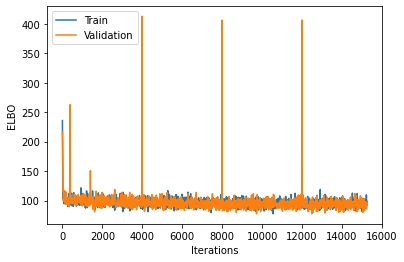

In [57]:
plot_loss(iters, train_loss, val_loss)

#### Our Answer

First, we can see both test and validation losses drop dramatically over the first few iterations.

From that moment on, for the most part the two graphs are similar in having ELBO loss of roughly 100 with a stochastic change around that number.

We must adress the spikes we see in the validation graph. These are an inevitable result of Mini-Batch Gradient Descent in Adam. Some mini-batches have unlucky data for the optimization, inducing those spikes we see in our cost function.

Visualize, from the test dataset, an original image against a reconstructed image. Has the model reconstructed the image successfully? Explain.

In [67]:
# Your Code Goes Here

def plot_reconstructed(model,test_loader):
      model.eval()
      for i,image in enumerate(test_loader):
        images,_ = image
        if torch.cuda.is_available():
          images = images.cuda()
        else:
          images = images.to(device)
        #reconstruct
        x_rec=model(images)
        fig, axes =plt.subplots(1,2)
        #plot 
        axes[0].imshow(x_rec[0].cpu().detach().numpy()[10].transpose(1,2,0))
        axes[0].set_title("Reconstruct")
        axes[0].axis('off')
        axes[1].imshow(images.cpu().detach().numpy()[10].transpose(1,2,0))
        axes[1].set_title("Original")
        axes[1].axis('off')
        plt.tight_layout()
        plt.show()
        break
      return 

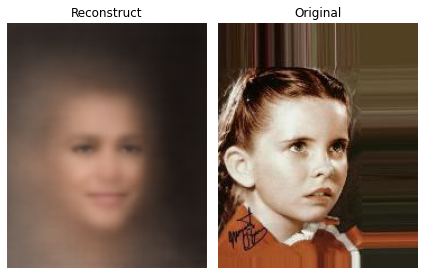

In [51]:
plot_reconstructed(model_1,test_loader)

#### Our Answer

We have managed to reconstruct a human face. However, we see that the image has very few details and looks like a general face floating in space. The facial features are not similar to the original image, nor are the background or posture of the person. 

We believe the lack of features is mostly due to our low dimension latent space and small number of epochs. Unfortunately, due to low computational power we couldn't change that much further and will only go up to latent space of 10 dimensions and maintain a small number of epochs.

### Part (c) -- 7%  

Next, we train with larger $L > 3$

Based on the results for $L = 3$, choose a larger $L$ to improve your results.
Train new model with your choice for $L$.

In [70]:
latent2 = 10 # TO DO: Choose latent space dimension.
num_epochs = 15  # smaller num of epochs to allow computation with decent time

if torch.cuda.is_available():
    model_2 = VAE(enc_in_chnl,enc_num_hidden,dec_in_chnl,dec_num_hidden,latent2, width = width, height = height).cuda()
    model_2.weight_init(mean=0, std=0.02)
else:
    model_2 = VAE(enc_in_chnl,enc_num_hidden,dec_in_chnl,dec_num_hidden,latent2, width = width, height = height)
    model_2.weight_init(mean=0, std=0.02)

Plot the train and the validation loss graphs. Explain what is seen.

In [71]:
# Your Code Goes Here
torch.cuda.empty_cache()
model_2 , iters_2, train_loss_2, val_loss_2 =  train(num_epochs,batch_size,dataset_size,model_2)

Epoch 0
TRAIN          Batch 0 ---- loss average 226.8038671875
VALIDATION     Batch 0 ---- loss average 207.8993359375
TRAIN          Batch 100 ---- loss average 76.3603076171875
VALIDATION     Batch 100 ---- loss average 76.3194775390625
TRAIN          Batch 200 ---- loss average 74.04162109375
VALIDATION     Batch 200 ---- loss average 74.1803271484375
TRAIN          Batch 300 ---- loss average 77.808408203125
VALIDATION     Batch 300 ---- loss average 71.0316943359375
TRAIN          Batch 400 ---- loss average 68.372431640625
VALIDATION     Batch 400 ---- loss average 73.812109375
TRAIN          Batch 500 ---- loss average 65.671796875
VALIDATION     Batch 500 ---- loss average 71.8195703125
TRAIN          Batch 600 ---- loss average 71.1601220703125
VALIDATION     Batch 600 ---- loss average 58.1686572265625
Epoch 1
TRAIN          Batch 0 ---- loss average 66.2667431640625
VALIDATION     Batch 0 ---- loss average 70.757890625
TRAIN          Batch 100 ---- loss average 62.096123046

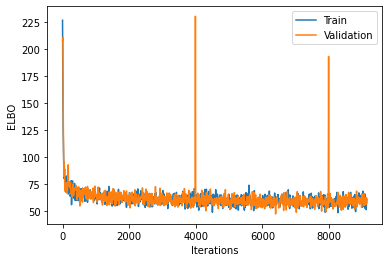

In [73]:
plot_loss(iters_2, train_loss_2, val_loss_2)

Visualize, from the test dataset, an original image against a reconstructed image. Has the model reconstructed the image successfully? Are the images identical? Explain.

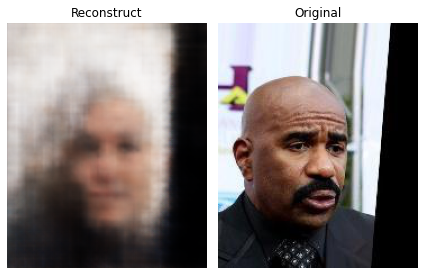

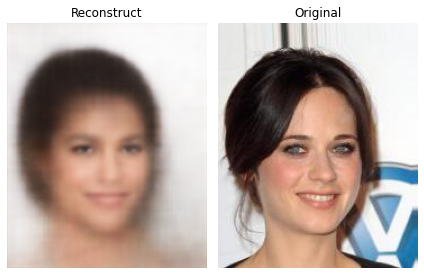

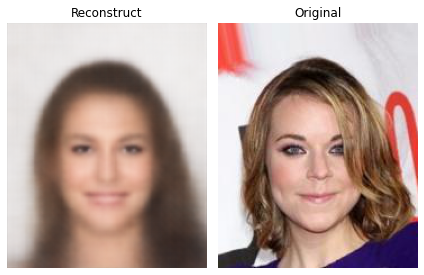

In [76]:
# Your Code Goes Here
plot_reconstructed(model_2,test_loader)
plot_reconstructed(model_2,test_loader)
plot_reconstructed(model_2,test_loader)

#### Our Answer

When we increase the dimension of the latent space we immediately see an increase in reconstruction details. The angles, hair style, background and skin tone were reconstructed much better with this model than the previous one.

Still this result is imperfect and much better reconstruction can be achieved with higher-dimension latent space or with using a GAN model.

 What will happened if we choose extremely high dimension for the latent space?

#### Our Answer

We can try using higher dimension for the latent space, and at the expense of computation time get better detail in our images.

However, if we chose an extremely high dimension we may face the high-dimensional small-sample-size (HDSSS) problem as published 10.1142/S1469026820500029.

This is because a high-dimensional latent space allows for a large number of possible configurations, which can make it difficult for the model to accurately capture the underlying structure of the data. The model would therefore be prone to overfitting.

 
Did you output blurry reconstructed images? If the answer is yes, explain what could be the reason. If you got sharp edges and fine details, explain what you did in order to achieve that. 

Note: If you got blurry reconstructed images, just explain why. You dont need to change your code or retrain your model for better results (as long as your results can be interpreted as a human face).
 

#### Our Answer

Yes, we output blurry images. There could be several reasons for our results:

1) Low Latent Space - as discussed, since we saved computation time by choosing a low latent space we miss details in our training.

2) Gaussianity assumption - we assume the distribution is gaussian, yet analize it with "weak" encoder and decoder networks, that are not very deep. These networks might not be powerful enough to capture the variation in the data.

3) KL Divergence - is less sensitive to the detail of the data.



While there are methods to overcome these issues, a GAN will probably yield better, sharper results, and the two methods are often encorporated togather.

## Question 6: Generate New Faces (10 %)

Now, for the fun part!

We are going to generate new celebrity faces with our VAE models. A function for new faces generation is given to you. Modify it (if needed) to fit your code. 



In [77]:
# creates random noise sample in the correct shape.
def generate_faces(model, grid_size, latent):
    model.eval()
    dummy = torch.empty([grid_size,latent])
    z = torch.randn_like(dummy).to(device)
    
    #insert the random noise to the decoder to create new samples.
    sample = model.decode(z)
    new_face_list = []

    j=0
    while j < grid_size: 
        new_face_list.append(sample[j].cpu().detach().numpy().transpose(1,2,0))
        j+=1

    show(new_face_list)

**Model 1 ($L = 3$) results:**

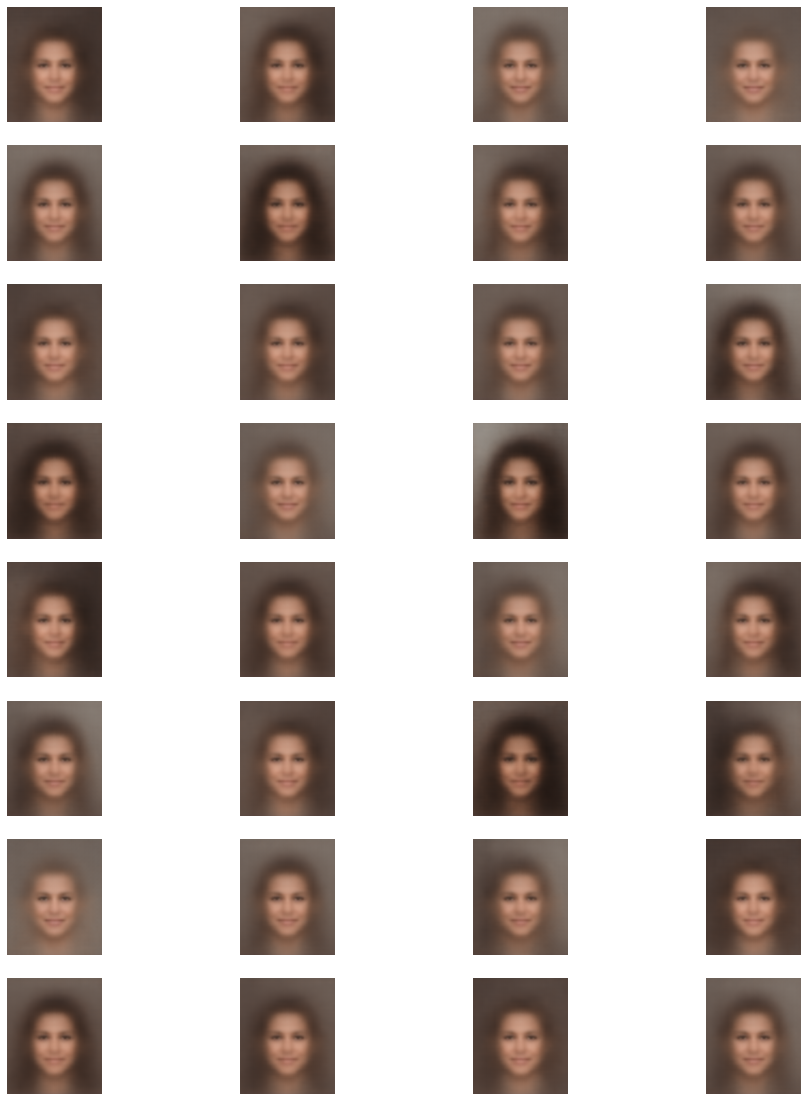

In [78]:
generate_faces(model_1,grid_size=32,latent=latent1)

**Model 2 results:**

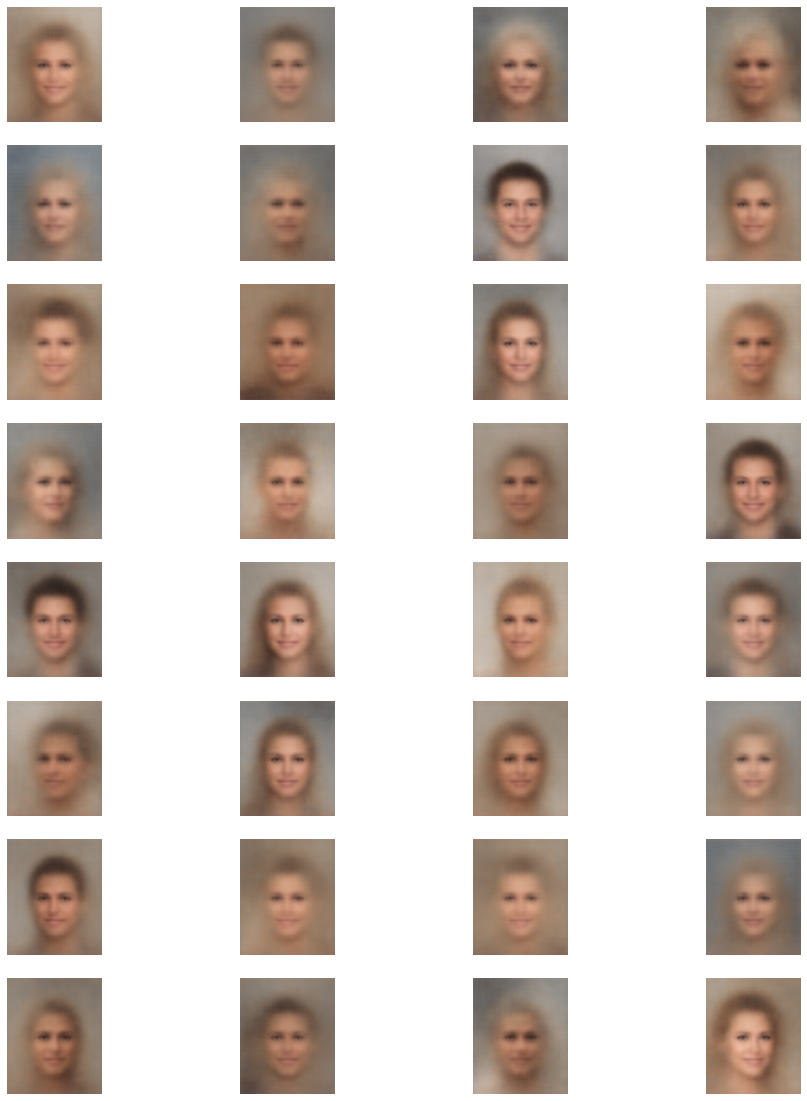

In [80]:
generate_faces(model_2,grid_size=32,latent=latent2)

*Q1:* Generate new faces with VAE model with latent space dimension = 3. Did you get diverse results? What are the most prominent features that the latent space capture? 

*Q2:* Generate new faces with VAE model with your decision for latent space dimension. What are the most prominent features that the latent space capture? 

*Q3:* What are the differences? Your results are similar to the dataset images? Do you get realistic images for your chosen latent space dimension? If not, change your decision or your network to acheive more realistic results.

#### Our Answer

##### Q1 Answer

Our 32 generated images are all similar to each other, varying mostly in the blurry shape of the hair. Thr most prominent features that the latent space capture are the eyes and mouth, and general shape of the face.
##### Q2 Answer

These images are slightly more diverse. In some we can also see now the hair line, and more clearly the shape of the nose and hair. We also get more shadow and viewing angles.
##### Q3 Answer

The higher dimension did give us slightly more detailed images. These images are also brighter than the ones produced with a small dimension.

Our results are not very similar to the dataset images. When trying to train with a greater latent space we encounter a memory problem that can not be overcome with our version of google colab, so this resolution is what we make due with.

## Question 7: Extrapolation (10 %)

Recall that we extrapolate in the images domain in Question 2, part (c).
Here, extrapolate in the latent space domain to generate new images.

Define $\beta = [0, 0.1, 0.2, ... , 0.9, 1]$ and randomly sample from $Z \sim \mathcal{N(0,1)}$ 2 different samples and generate 2 new face images: $X_1, X_2$.

Extrapolate in the latent domain as follows: $\beta_i\cdot Z_1 + (1-\beta_i)\cdot Z_2$ for each $\beta_i \in \beta$.

Plot the extrapolation of the images for each $\beta$ and discuss your results. 
Repeat the process for 3 different samples.



In [89]:
# YOUR CODE GOES HERE
def Extrapolate(model, latent):
  model.eval()
  
  dummy1 = torch.empty([1,3]) 
  z1 = torch.randn_like(dummy1).to(device)
  dummy2 = torch.empty([1,3]) 
  z2 = torch.randn_like(dummy2).to(device)

  beta = (np.linspace(0, 1, 11)).tolist()
  image1 = model.decode(z1) 
  image2 = model.decode(z2)
  fig, axes = plt.subplots(1,2)
  axes[0].imshow(image1.cpu().detach().numpy()[0].transpose(1,2,0))
  axes[0].set_title("Image 1 - Z_1")
  axes[0].axis('off')
  axes[1].imshow(image2.cpu().detach().numpy()[0].transpose(1,2,0))
  axes[1].set_title("Image 2 - Z_2")
  axes[1].axis('off')
  plt.show()

  for i in range(10):
    plt.subplot(2,5,i+1)
    combine = model.decode(beta[i]*z1+(1-beta[i])*z2) #b*z_1 +(1-b)*z_2
    plt.imshow(combine[0].cpu().permute(1,2,0).detach().numpy())
    plt.axis('off')
  plt.show()



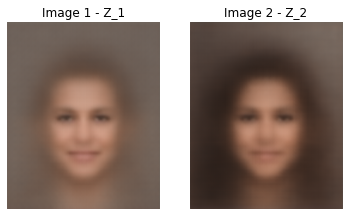

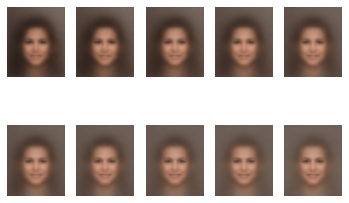

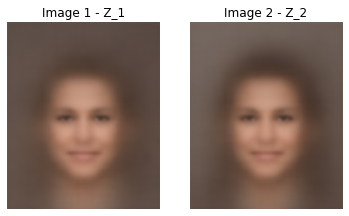

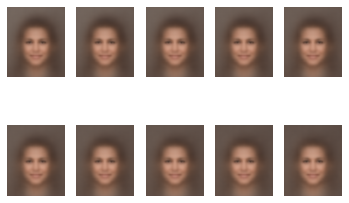

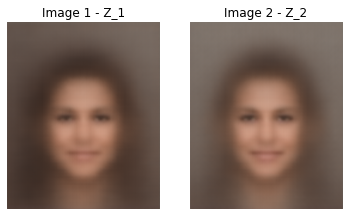

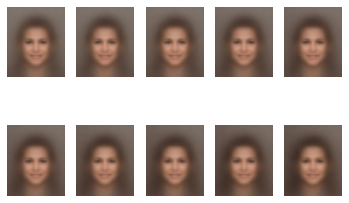

In [90]:
model_1.eval() 
for i in range(3):
    Extrapolate(model_1, latent=latent1)

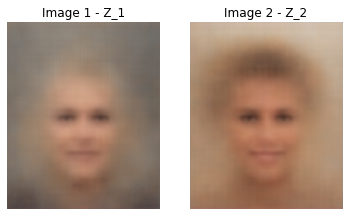

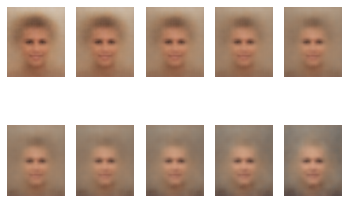

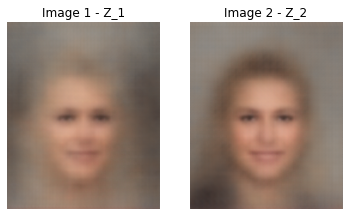

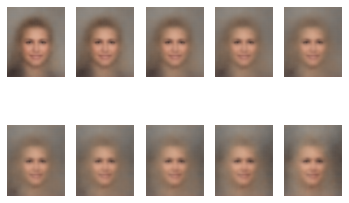

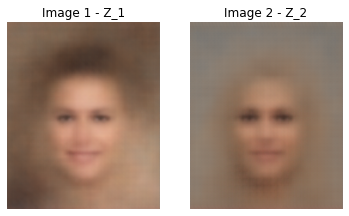

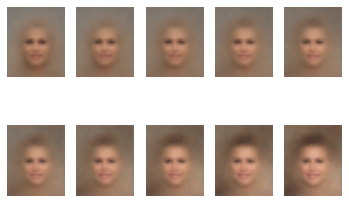

In [91]:
model_2.eval() 
for i in range(3):
    Extrapolate(model_2, latent=latent2)

#### Our Answer

Since our starting images are blurred out, it's hard to tell how good the extrapulation results are. We do see a difference when changing $\beta$, indeed when $\beta=0$ or $\beta=1$ we see one of the images, and any number in between shows a slightly different image, varying from the first to second.